# Immgen ATAC-Seq

Logbook: https://docs.google.com/document/d/1WxzLWUX0PV2TpD0VfwStHczN6YSQ35Uu6DDR-8WX-io/edit#heading=h.xg4nq1px6lhh

In [53]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
import re

In [54]:
PATH = os.path.expanduser('~/data/2024_Immgen')
! mkdir -p {PATH}/pics

def file_to_name(file):
    return re.sub('(.*SRR[0-9]+_)|(_ATAC_seq.*)', '', os.path.basename(file))

def file_to_srr(file):
    return re.sub('_.*', '', os.path.basename(file))

In [55]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0) # Empty file

def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0 # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

# Load peaks

In [56]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

/tmp/ipykernel_2545207/386494431.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


In [57]:
def atac_load_peaks(path, suffix):
    df = pd.DataFrame(columns=['file', 'peaks'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        file = os.path.join(path, f)
        ps = lines(file)
        df.loc[len(df)] = (file, ps)
    return df


def atac_load_peaks_path(path):
    df_macs2 = atac_load_peaks(os.path.join(path, 'macs2'), '.narrowPeak')
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2_broad = atac_load_peaks(os.path.join(path, 'macs2'), '.broadPeak')
    df_macs2_broad['tool'] = 'MACS2 broad'
    print('MACS2', len(df_macs2_broad))


    df_sicer = atac_load_peaks(os.path.join(path, 'sicer'), '.scoreisland')
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = atac_load_peaks(os.path.join(path, 'span'), '.peak')
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2_broad, df_sicer, df_span]).reset_index(drop=True)

In [58]:
dfa = atac_load_peaks_path(PATH)
dfa['name'] = [file_to_name(f) for f in dfa['file']]
dfa['srr']  = [file_to_srr(f) for f in dfa['file']]
dfa.sort_values(by='name', inplace=True)
dfa.sample(3)

  0%|          | 0/64 [00:00<?, ?it/s]

MACS2 8


  0%|          | 0/64 [00:00<?, ?it/s]

MACS2 8


  0%|          | 0/6 [00:00<?, ?it/s]

SICER 6


  0%|          | 0/33 [00:00<?, ?it/s]

SPAN 8


,file,peaks,tool,name,srr
28,/home/jetbrains/data/2024_Immgen/span/SRR57995...,49317,SPAN,Blood_Monocyte,SRR5799541
19,/home/jetbrains/data/2024_Immgen/sicer/SRR5799...,43285,SICER,Blood_Monocyte,SRR5799491
3,/home/jetbrains/data/2024_Immgen/macs2/SRR5799...,47240,MACS2,Blood_Monocyte,SRR5799491


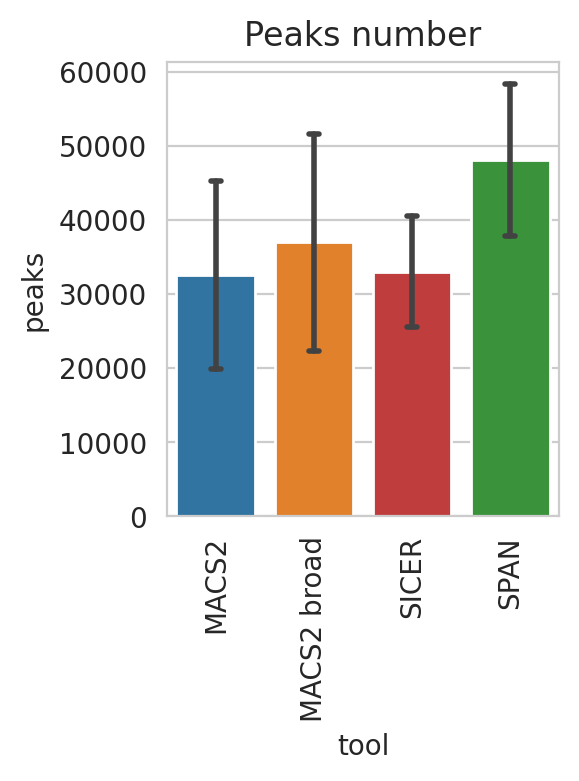

In [59]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
sns.barplot(data=dfa, x='tool', y='peaks',
            order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
            palette=TOOLS_PALETTE,
            errorbar='sd', capsize=.1, errwidth=2,
            ax=ax)
# sns.swarmplot(data=dfa, x='tool', y='peaks',
#               order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
#               color='black',
#               dodge=True, size=2, alpha=0.5,
#               legend=False,
#               ax=ax)
plt.xticks(rotation=90)
plt.title('Peaks number')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

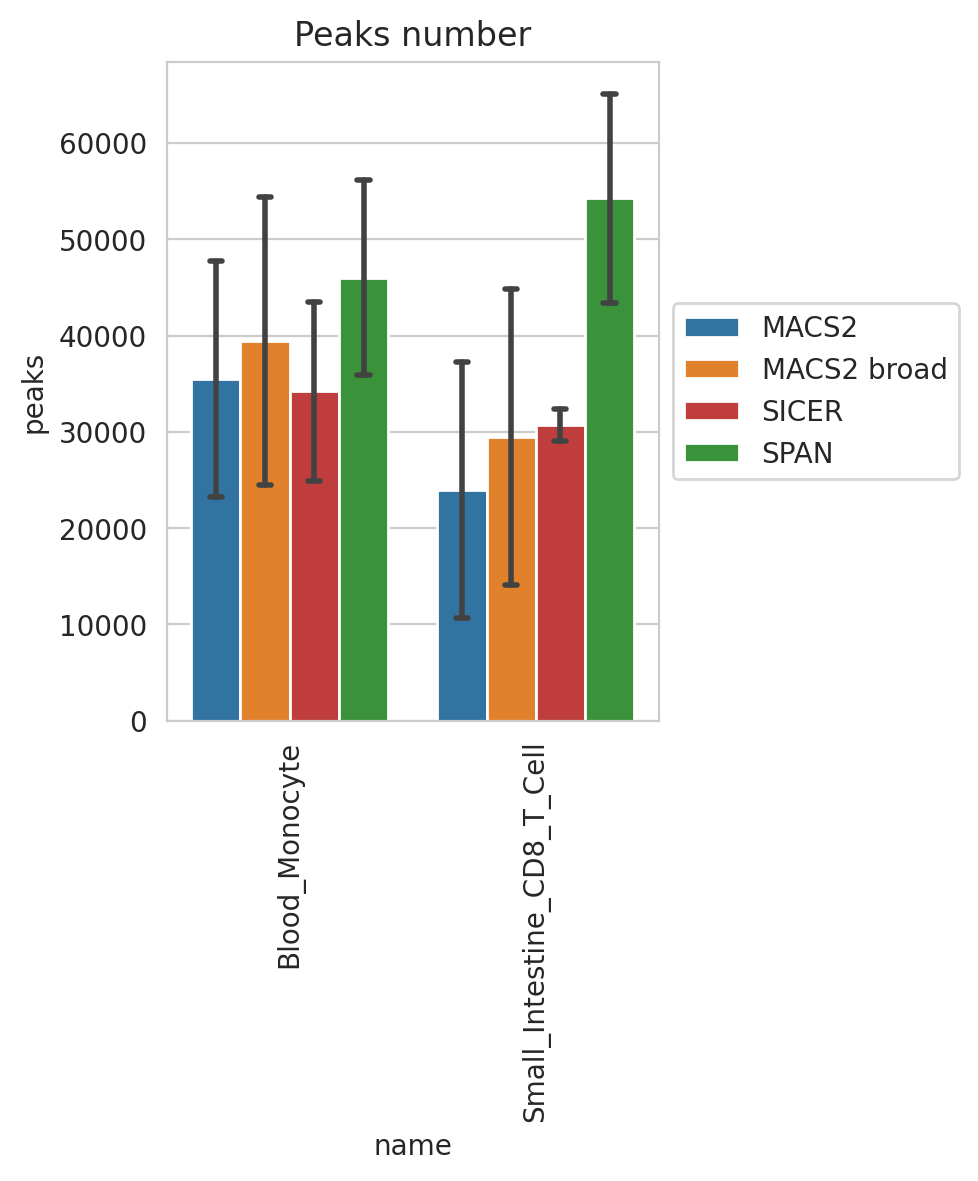

In [60]:
plt.figure(figsize=(5, 6))
g_result = sns.barplot(data=dfa, x='name', y='peaks', hue='tool',
                       hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                       palette=TOOLS_PALETTE,
                       errorbar='sd', capsize=.05, errwidth=2)
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.title('Peaks number')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [61]:
dfa[dfa['tool'] == 'MACS2 broad'].groupby(['name'])['file'].count().astype(int)

name
Blood_Monocyte                6
Small_Intestine_CD8_T_Cell    2
Name: file, dtype: int64

In [62]:
ts = []
for srr, name, tool, file in tqdm(zip(dfa['srr'], dfa['name'], dfa['tool'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    # Some tracks may have open chromatin clusters, which significantly affects average, 
    # so pick only lengths limited to 90%
    # t.sort_values(by=['length'], inplace=True)
    # t = t.iloc[0:int(len(t) * 0.9)].copy()
    t = t.sample(min(len(t), 10_000)).copy()
    t['srr'] = srr
    t['name'] = name
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,length,srr,name,tool
176792,138,SRR5799491,Blood_Monocyte,MACS2
11466,380,SRR5799491,Blood_Monocyte,SPAN
239590,148,SRR5799444,Small_Intestine_CD8_T_Cell,MACS2 broad
272966,155,SRR5799445,Small_Intestine_CD8_T_Cell,MACS2
264234,170,SRR5799444,Small_Intestine_CD8_T_Cell,MACS2
148589,260,SRR5799493,Blood_Monocyte,SPAN
275149,230,SRR5799445,Small_Intestine_CD8_T_Cell,MACS2
236955,115,SRR5799444,Small_Intestine_CD8_T_Cell,MACS2 broad
72153,1560,SRR5799541,Blood_Monocyte,SPAN
247983,12199,SRR5799445,Small_Intestine_CD8_T_Cell,SICER


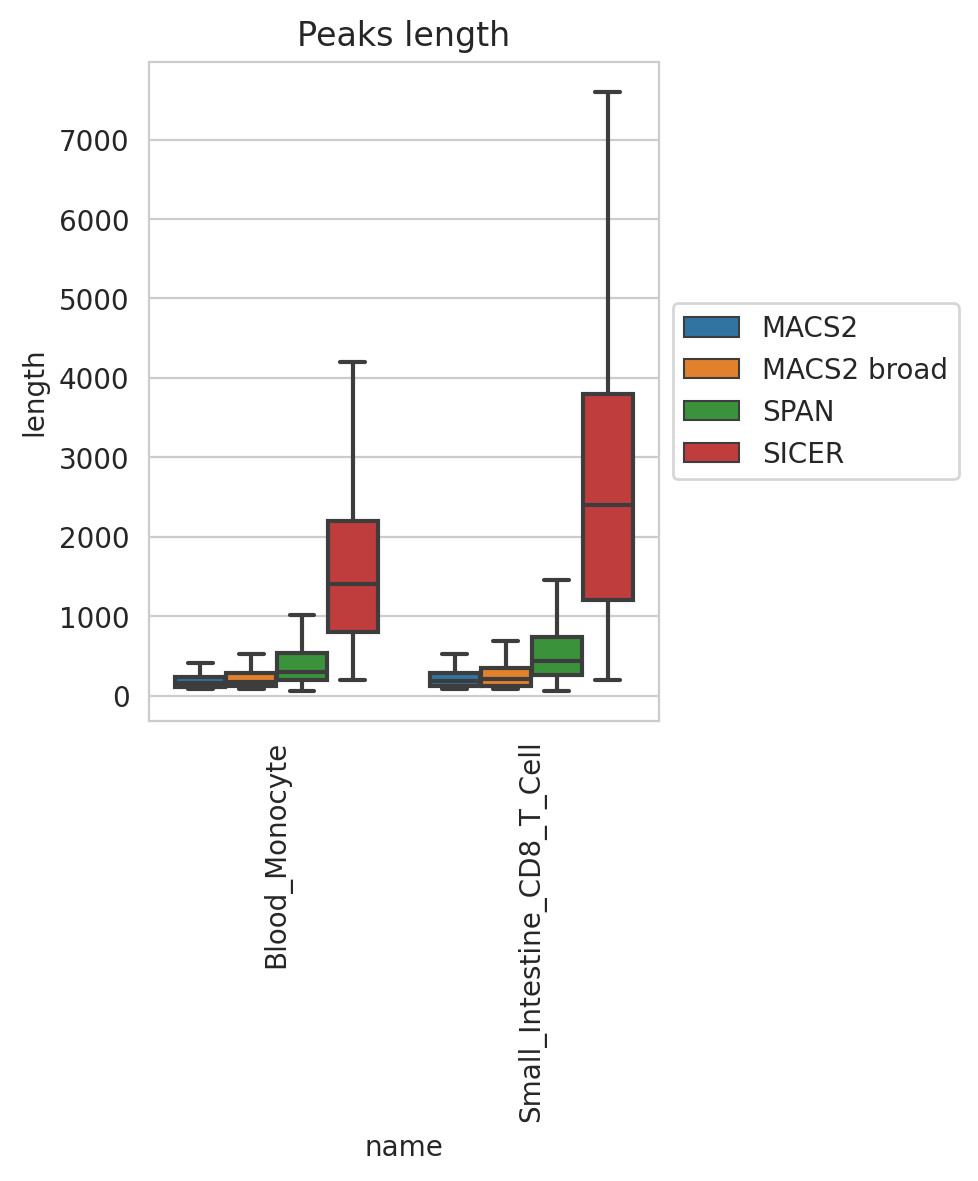

In [63]:
plt.figure(figsize=(5, 6))
g_result = sns.boxplot(data=t, x='name', y='length', hue='tool',
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       palette=TOOLS_PALETTE,
                       showfliers=False)
plt.xticks(rotation=90)
plt.title('Peaks length')
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/peaks_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

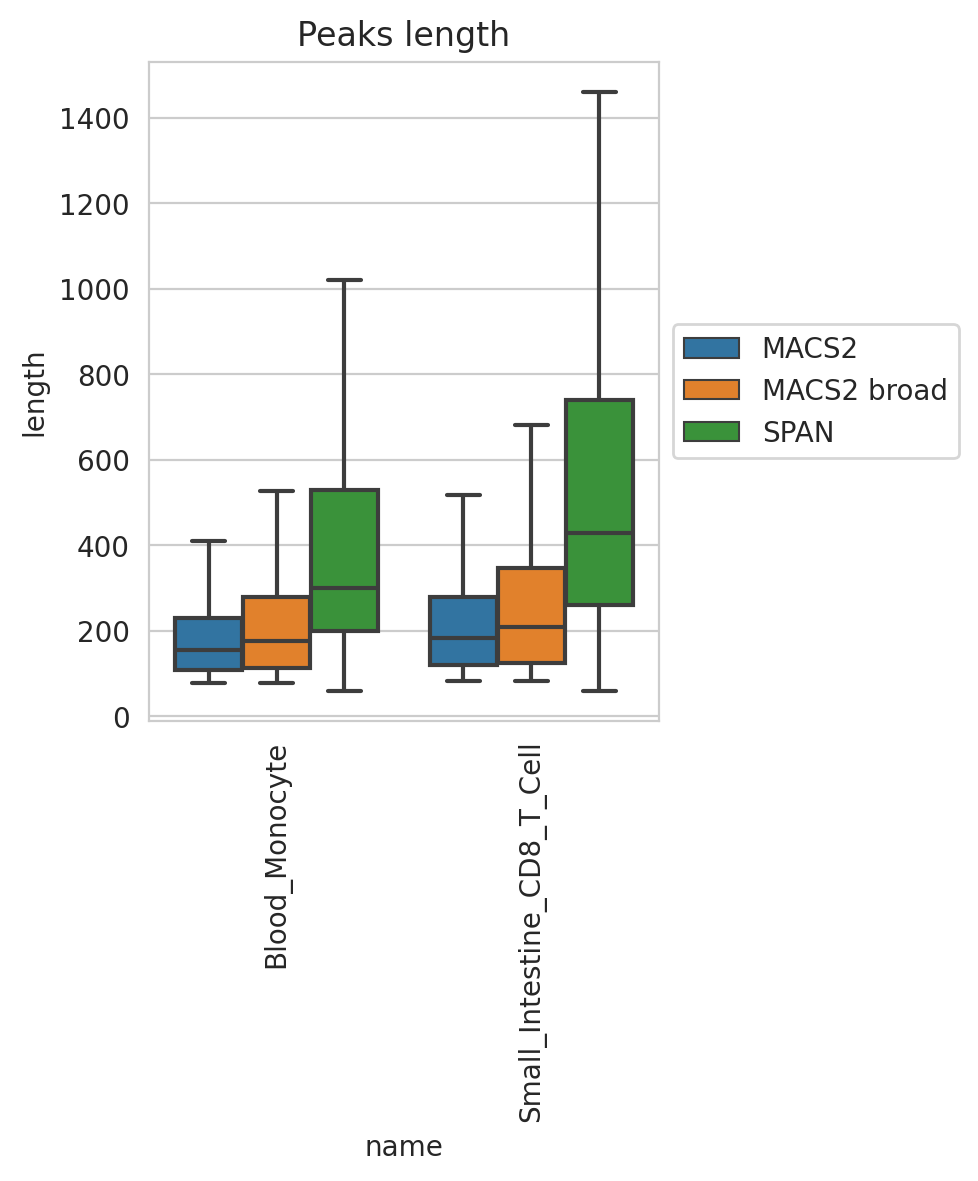

In [64]:
plt.figure(figsize=(5, 6))
g_result = sns.boxplot(data=t[t['tool'] != 'SICER'], x='name', y='length', hue='tool',
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN'],
                       palette=TOOLS_PALETTE,
                       showfliers=False)
plt.xticks(rotation=90)
plt.title('Peaks length')
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/peaks_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

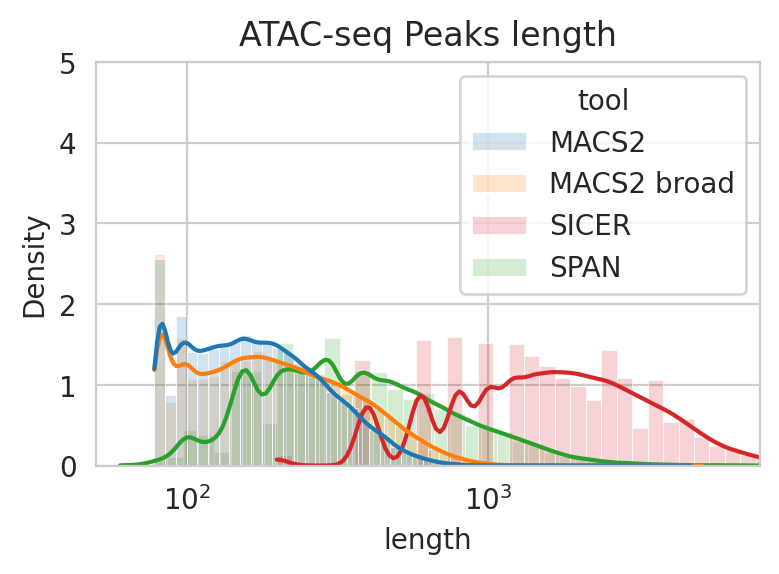

In [65]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.set_ylim(0, 5)
g_results.set_xlim(50, 8e3)
ax.title.set_text('ATAC-seq Peaks length')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks_length2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [66]:
df_lens_aggr = t[t['tool'] != 'SICER'].groupby(['srr', 'name', 'tool']).agg('mean').reset_index().drop_duplicates()
df_lens_aggr.sort_values(by=['length'], ascending=False, inplace=True)
df_lens_aggr.head(10)

,srr,name,tool,length
5,SRR5799445,Small_Intestine_CD8_T_Cell,SPAN,638.0299
2,SRR5799444,Small_Intestine_CD8_T_Cell,SPAN,571.0830
14,SRR5799493,Blood_Monocyte,SPAN,498.6410
23,SRR5799542,Blood_Monocyte,SPAN,477.0969
17,SRR5799494,Blood_Monocyte,SPAN,456.0270
20,SRR5799541,Blood_Monocyte,SPAN,397.4610
8,SRR5799491,Blood_Monocyte,SPAN,389.2180
11,SRR5799492,Blood_Monocyte,SPAN,376.1150
4,SRR5799445,Small_Intestine_CD8_T_Cell,MACS2 broad,274.1252
13,SRR5799493,Blood_Monocyte,MACS2 broad,246.0869


# Overlaps

In [67]:
! mkdir {PATH}/overlaps
import tempfile
from itertools import product

def compute_overlaps(df):
    tf = tempfile.mktemp()
    dfoverlap = pd.DataFrame(columns=['name', 'tool', 'file1', 'file2',
                                      'peaks1', 'peaks2', 'overlap12', 'overlap21',
                                      'peaks1_len', 'peaks2_len', 'overlap_len'], dtype=object)
    for (name, tool), dft in tqdm(list(df.groupby(['name', 'tool']))):
        print('Processing', name, tool, len(dft))
        if len(dft) < 2:
            continue
        files = list(dft['file'])
        for i1, i2 in product(range(len(files)), range(len(files))):
            if i1 >= i2:
                continue
            f1, f2 = files[i1], files[i2]
            peaks1, peaks1_len = lines(f1), bedl(f1).sum()
            peaks2, peaks2_len = lines(f2), bedl(f2).sum()
            f1s, f2s = sorted_file(f1), sorted_file(f2)
            !bedtools intersect -a {f1s} -b {f2s} -wa -u > {tf}
            overlap12 = lines(tf)
            !bedtools intersect -b {f1s} -a {f2s} -wa -u > {tf}
            overlap21 = lines(tf)
            !bedtools intersect -a {f1s} -b {f2s} -wo > {tf}
            overlap_len = int(last_col(tf).sum())
            dfoverlap.loc[len(dfoverlap)] = (name, tool, f1, f2,
                                             peaks1, peaks2, overlap12, overlap21,
                                             peaks1_len, peaks2_len, overlap_len)
    return dfoverlap

mkdir: cannot create directory ‘/home/jetbrains/data/2024_Immgen/overlaps’: File exists


In [68]:
df_overlap = compute_overlaps(dfa)

  0%|          | 0/8 [00:00<?, ?it/s]

Processing Blood_Monocyte MACS2 6
Processing Blood_Monocyte MACS2 broad 6
Processing Blood_Monocyte SICER 4
Processing Blood_Monocyte SPAN 6
Processing Small_Intestine_CD8_T_Cell MACS2 2
Processing Small_Intestine_CD8_T_Cell MACS2 broad 2
Processing Small_Intestine_CD8_T_Cell SICER 2
Processing Small_Intestine_CD8_T_Cell SPAN 2


In [69]:
df_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(df_overlap['peaks1_len'], df_overlap['peaks2_len'], df_overlap['overlap_len'])
]
df_overlap.sort_values(by='name', inplace=True)

Jaccard


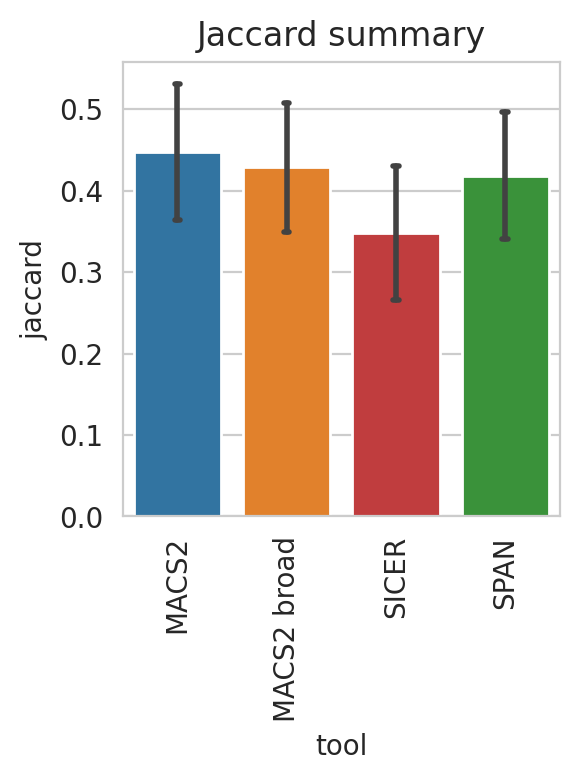

In [70]:
print('Jaccard')

plt.figure(figsize=(3, 4))
g_result = sns.barplot(data=df_overlap,
                       x='tool', y='jaccard',
                       order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                       palette=TOOLS_PALETTE,
                       errorbar='sd', capsize=.05, errwidth=2)
plt.xticks(rotation=90)
plt.title('Jaccard summary')
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

Jaccard


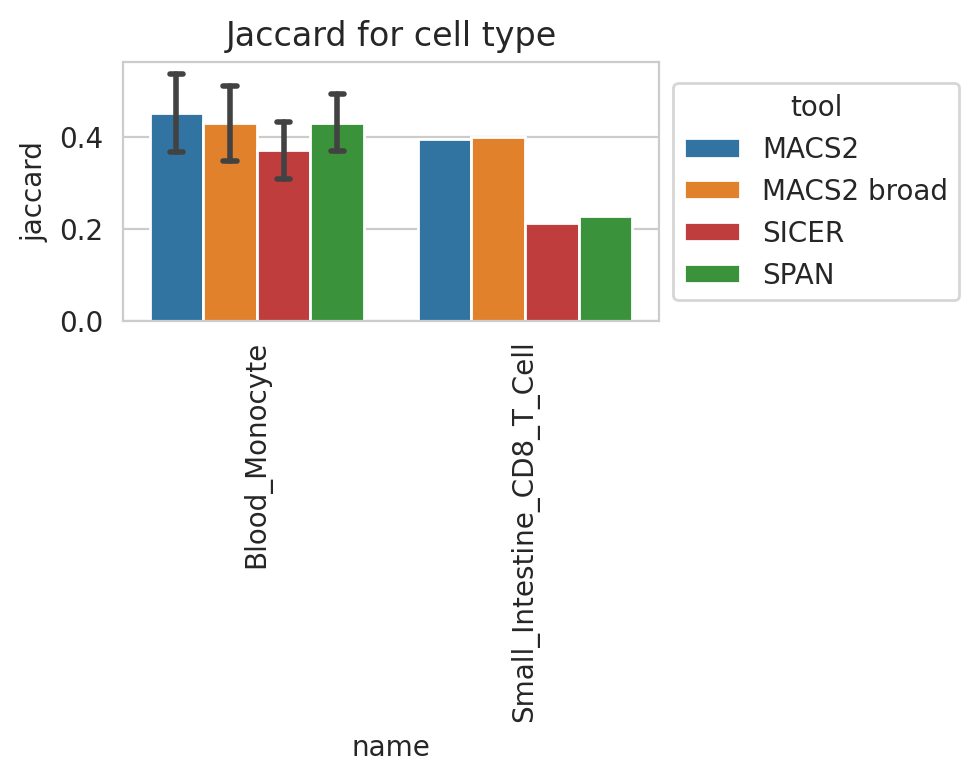

In [71]:
print('Jaccard')

plt.figure(figsize=(5, 4))
ax = plt.axes()
sns.barplot(data=df_overlap,
            x='name', y='jaccard',
            hue='tool',
            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
            palette=TOOLS_PALETTE,
            errorbar='sd', capsize=.05, errwidth=2,
            ax=ax)
plt.xticks(rotation=90)
plt.title('Jaccard for cell type')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference

In [72]:
diff_bench_df = pd.DataFrame(
    columns=['cell', 'srr', 'name', 'peaks'],
    dtype=object
)

tf = tempfile.mktemp()

for srr in tqdm(dfa['srr'].unique()):
    print(srr)
    t = dfa[(dfa['tool'] == 'SPAN') & (dfa['srr'] == srr)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    cell_name = t['name'].values[0]
    # Processing single tools information
    for tool in dfa['tool'].unique():
        if tool == 'SPAN':
            continue
        t = dfa[(dfa['tool'] == tool) & (dfa['srr'] == srr)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
            !echo '' > {tf}
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            diff_bench_df.loc[len(diff_bench_df)] = (cell_name, srr, name, peaks)
diff_bench_df

  0%|          | 0/8 [00:00<?, ?it/s]

SRR5799494
SRR5799491
SRR5799492
SRR5799493
SRR5799541
SRR5799542
SRR5799444
SRR5799445


,cell,srr,name,peaks
0,Blood_Monocyte,SRR5799494,SPAN - MACS2,14186
1,Blood_Monocyte,SRR5799494,MACS2 - SPAN,145
2,Blood_Monocyte,SRR5799494,SPAN - SICER,9262
3,Blood_Monocyte,SRR5799494,SICER - SPAN,1427
4,Blood_Monocyte,SRR5799494,SPAN - MACS2 broad,12366
5,Blood_Monocyte,SRR5799494,MACS2 broad - SPAN,180
6,Blood_Monocyte,SRR5799491,SPAN - MACS2,18565
7,Blood_Monocyte,SRR5799491,MACS2 - SPAN,94
8,Blood_Monocyte,SRR5799491,SPAN - SICER,11826
9,Blood_Monocyte,SRR5799491,SICER - SPAN,923


Diff


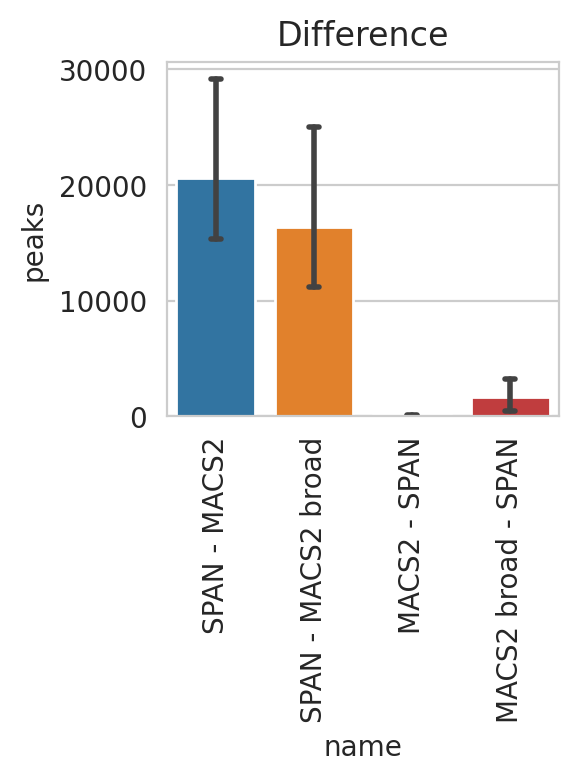

In [73]:
print('Diff')

plt.figure(figsize=(3, 4))
g_result = sns.barplot(data=diff_bench_df,
                       x='name', y='peaks',
                       # order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER', 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN'],
                       order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'MACS2 - SPAN', 'MACS2 broad - SPAN'],
                       capsize=.1, errwidth=2,
                       )
plt.xticks(rotation=90)
plt.title('Difference')
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/difference.pdf', bbox_inches='tight', dpi=300)
plt.show()

Diff


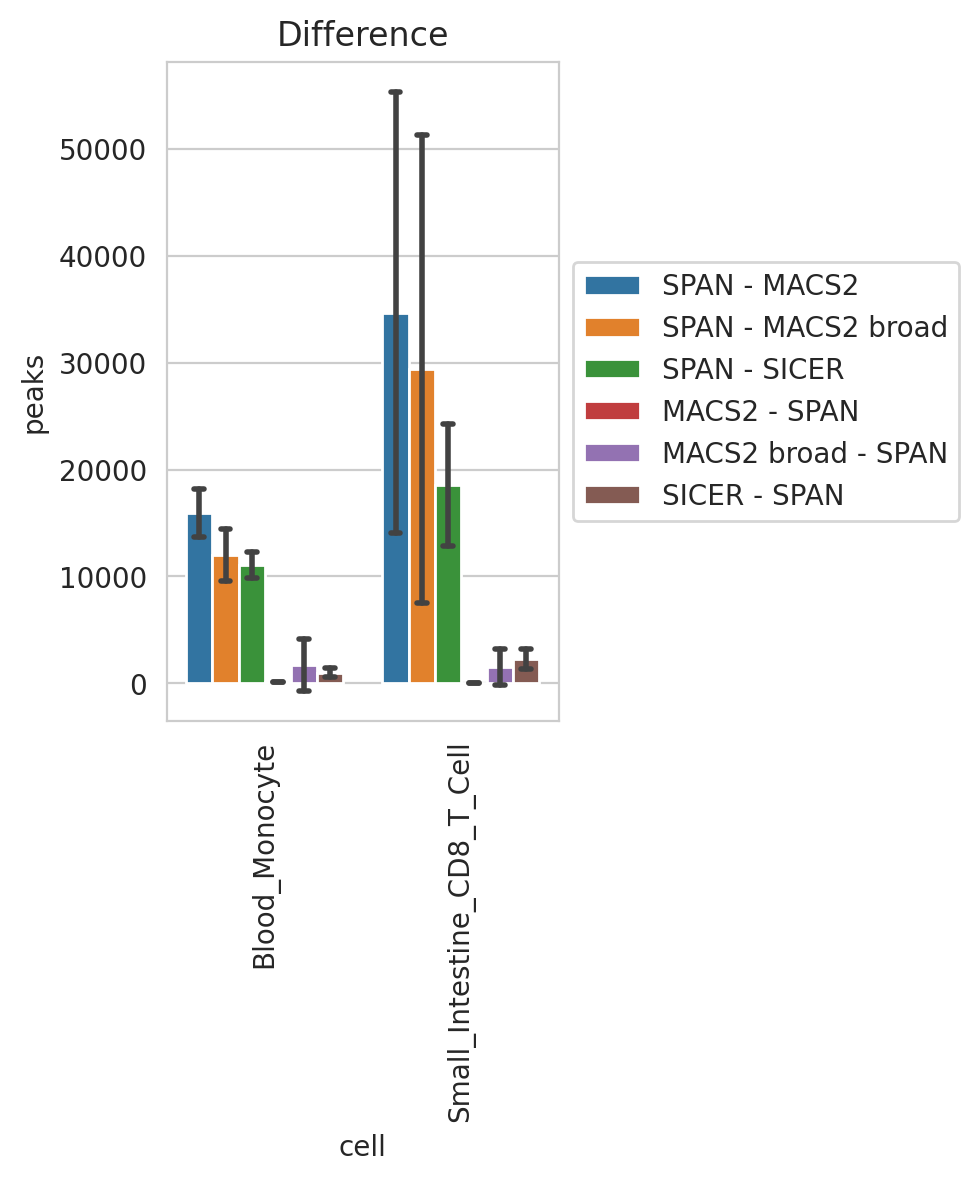

In [74]:
print('Diff')

plt.figure(figsize=(5, 6))
g_result = sns.barplot(data=diff_bench_df,
                       x='cell', y='peaks', hue='name',
                       hue_order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER', 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN'],
                       errorbar='sd', capsize=.05, errwidth=2,
                       )
plt.xticks(rotation=90)
plt.title('Difference')
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/difference.pdf', bbox_inches='tight', dpi=300)
plt.show()

# IDR between replicates

In [236]:
    # from tempfile import mktemp
# 
# def compute_idrs(df):
#     dfidr = pd.DataFrame(columns=['name', 'tool', 'rep1', 'rep2', 
#                                   'idr_peaks', 'idr_loaded_peaks', 'idr_percentage'], dtype=object)
#     tf = mktemp()
#     for (name, tool), dft in tqdm(list(df.groupby(['name', 'tool']))):
#         print('Processing', name, tool, len(dft))
#         files = list(dft['file'])
#         for i1, i2 in product(range(len(files)), range(len(files))):
#             if i1 >= i2:
#                 continue
#             f1, f2 = sorted_file(files[i1]), sorted_file(files[i2])
#             # Process SICER peaks, add missing 8th column, as -log10 qvalue
#             if tool == 'SICER':
#                 sf1 = pd.read_csv(f1, sep='\t', header=None)
#                 sf1[8] = -np.log10(sf1[7])
#                 sf1.to_csv(f1, sep='\t', index=None, header=False)
#                 sf2 = pd.read_csv(f2, sep='\t', header=None)
#                 sf2[8] = -np.log10(sf2[7])
#                 sf2.to_csv(f2, sep='\t', index=None, header=False)
#             ! idr --input-file-type bed --rank 8 --samples {f1} {f2} 2>&1 | tee {tf}
#             with open(tf) as f:
#                 idr_out = f.read()
#             ip, ilp, iperc = re.findall('Number of peaks passing IDR cutoff of 0.05 - (\\d+)/(\\d+) \\(([\\d\\.]+)', idr_out)[0]
#             ip, ilp, iperc = int(ip), int(ilp), float(iperc)                
#             dfidr.loc[len(dfidr)] = (name, tool, i1, i2, ip, ilp, iperc)
#     return dfidr

In [237]:
# df_idr = compute_idrs(dfa)

In [238]:
# print('IDR')
# 
# plt.figure(figsize=(14, 6))
# g_result = sns.barplot(data=df_idr,
#                        x='name', y='idr_peaks', hue='tool',
#                        errorbar='sd', capsize=.05, errwidth=2)
# plt.xticks(rotation=90)
# plt.title('IDR for cell type')
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.tight_layout()
# plt.savefig(f'{PATH}/pics/idr.pdf', bbox_inches='tight', dpi=300)
# plt.show()

# Overlap with DHS

In [75]:
from itertools import product

DHS_PATH = f'{PATH}/ENCFF754WCT_mm10_dhs_representative_sites.bed'
dhs_path_sorted = sorted_file(DHS_PATH)
DHS_PEAKS = lines(DHS_PATH)

def compute_dhs_overlaps(df):
    dfoverlap = pd.DataFrame(columns=['srr', 'name', 'tool', 'file', 'way', 'peaks', 'overlap'], dtype=object)
    for (srr, name, tool), dft in tqdm(list(df.groupby(['srr', 'name', 'tool']))):
        print('Processing', srr, name, tool, len(dft))
        for _, row in dft.iterrows():
            file, peaks = sorted_file(row['file']), row['peaks']

            tf = f'{PATH}/overlaps/overlaps_{tool}_{name}_{tool}_vs_dhs.bed'.replace(' ', '_')
            !bedtools intersect -a {file} -b {dhs_path_sorted} -wa -u > {tf}
            owd = lines(tf)
            dfoverlap.loc[len(dfoverlap)] = (srr, name, tool, file, 'with_dhs', peaks, owd)

            tf = f'{PATH}/overlaps/overlaps_{tool}_{name}_{tool}_dhs_vs.bed'.replace(' ', '_')
            !bedtools intersect -b {file} -a {dhs_path_sorted} -wa -u > {tf}
            odw = lines(tf)
            dfoverlap.loc[len(dfoverlap)] = (srr, name, tool, file, 'dhs_with', DHS_PEAKS, odw)
    return dfoverlap

In [76]:
dhs_overlap = compute_dhs_overlaps(dfa[dfa['tool'] != 'SICER'])
dhs_overlap.sample(3)

  0%|          | 0/24 [00:00<?, ?it/s]

Processing SRR5799444 Small_Intestine_CD8_T_Cell MACS2 1
Processing SRR5799444 Small_Intestine_CD8_T_Cell MACS2 broad 1
Processing SRR5799444 Small_Intestine_CD8_T_Cell SPAN 1
Processing SRR5799445 Small_Intestine_CD8_T_Cell MACS2 1
Processing SRR5799445 Small_Intestine_CD8_T_Cell MACS2 broad 1
Processing SRR5799445 Small_Intestine_CD8_T_Cell SPAN 1
Processing SRR5799491 Blood_Monocyte MACS2 1
Processing SRR5799491 Blood_Monocyte MACS2 broad 1
Processing SRR5799491 Blood_Monocyte SPAN 1
Processing SRR5799492 Blood_Monocyte MACS2 1
Processing SRR5799492 Blood_Monocyte MACS2 broad 1
Processing SRR5799492 Blood_Monocyte SPAN 1
Processing SRR5799493 Blood_Monocyte MACS2 1
Processing SRR5799493 Blood_Monocyte MACS2 broad 1
Processing SRR5799493 Blood_Monocyte SPAN 1
Processing SRR5799494 Blood_Monocyte MACS2 1
Processing SRR5799494 Blood_Monocyte MACS2 broad 1
Processing SRR5799494 Blood_Monocyte SPAN 1
Processing SRR5799541 Blood_Monocyte MACS2 1
Processing SRR5799541 Blood_Monocyte MACS2 

,srr,name,tool,file,way,peaks,overlap
20,SRR5799492,Blood_Monocyte,MACS2 broad,/tmp/tmp8uvzhdfz,with_dhs,24741,24166
41,SRR5799541,Blood_Monocyte,SPAN,/tmp/tmpag8w0a5q,dhs_with,1192301,70613
42,SRR5799542,Blood_Monocyte,MACS2,/tmp/tmp_xp4rqsx,with_dhs,18272,17843


In [77]:
dhs_overlap['overlap_share'] = [o / p if p > 0 else 0 for o, p in zip(dhs_overlap['overlap'], dhs_overlap['peaks'])]
dhs_overlap.sample(3)

,srr,name,tool,file,way,peaks,overlap,overlap_share
30,SRR5799494,Blood_Monocyte,MACS2,/tmp/tmpkwgd5rm4,with_dhs,37320,36115,0.967712
25,SRR5799493,Blood_Monocyte,MACS2,/tmp/tmpxbc6rv4x,dhs_with,1192301,48156,0.040389
9,SRR5799445,Small_Intestine_CD8_T_Cell,MACS2 broad,/tmp/tmpw4oumy28,dhs_with,1192301,22023,0.018471


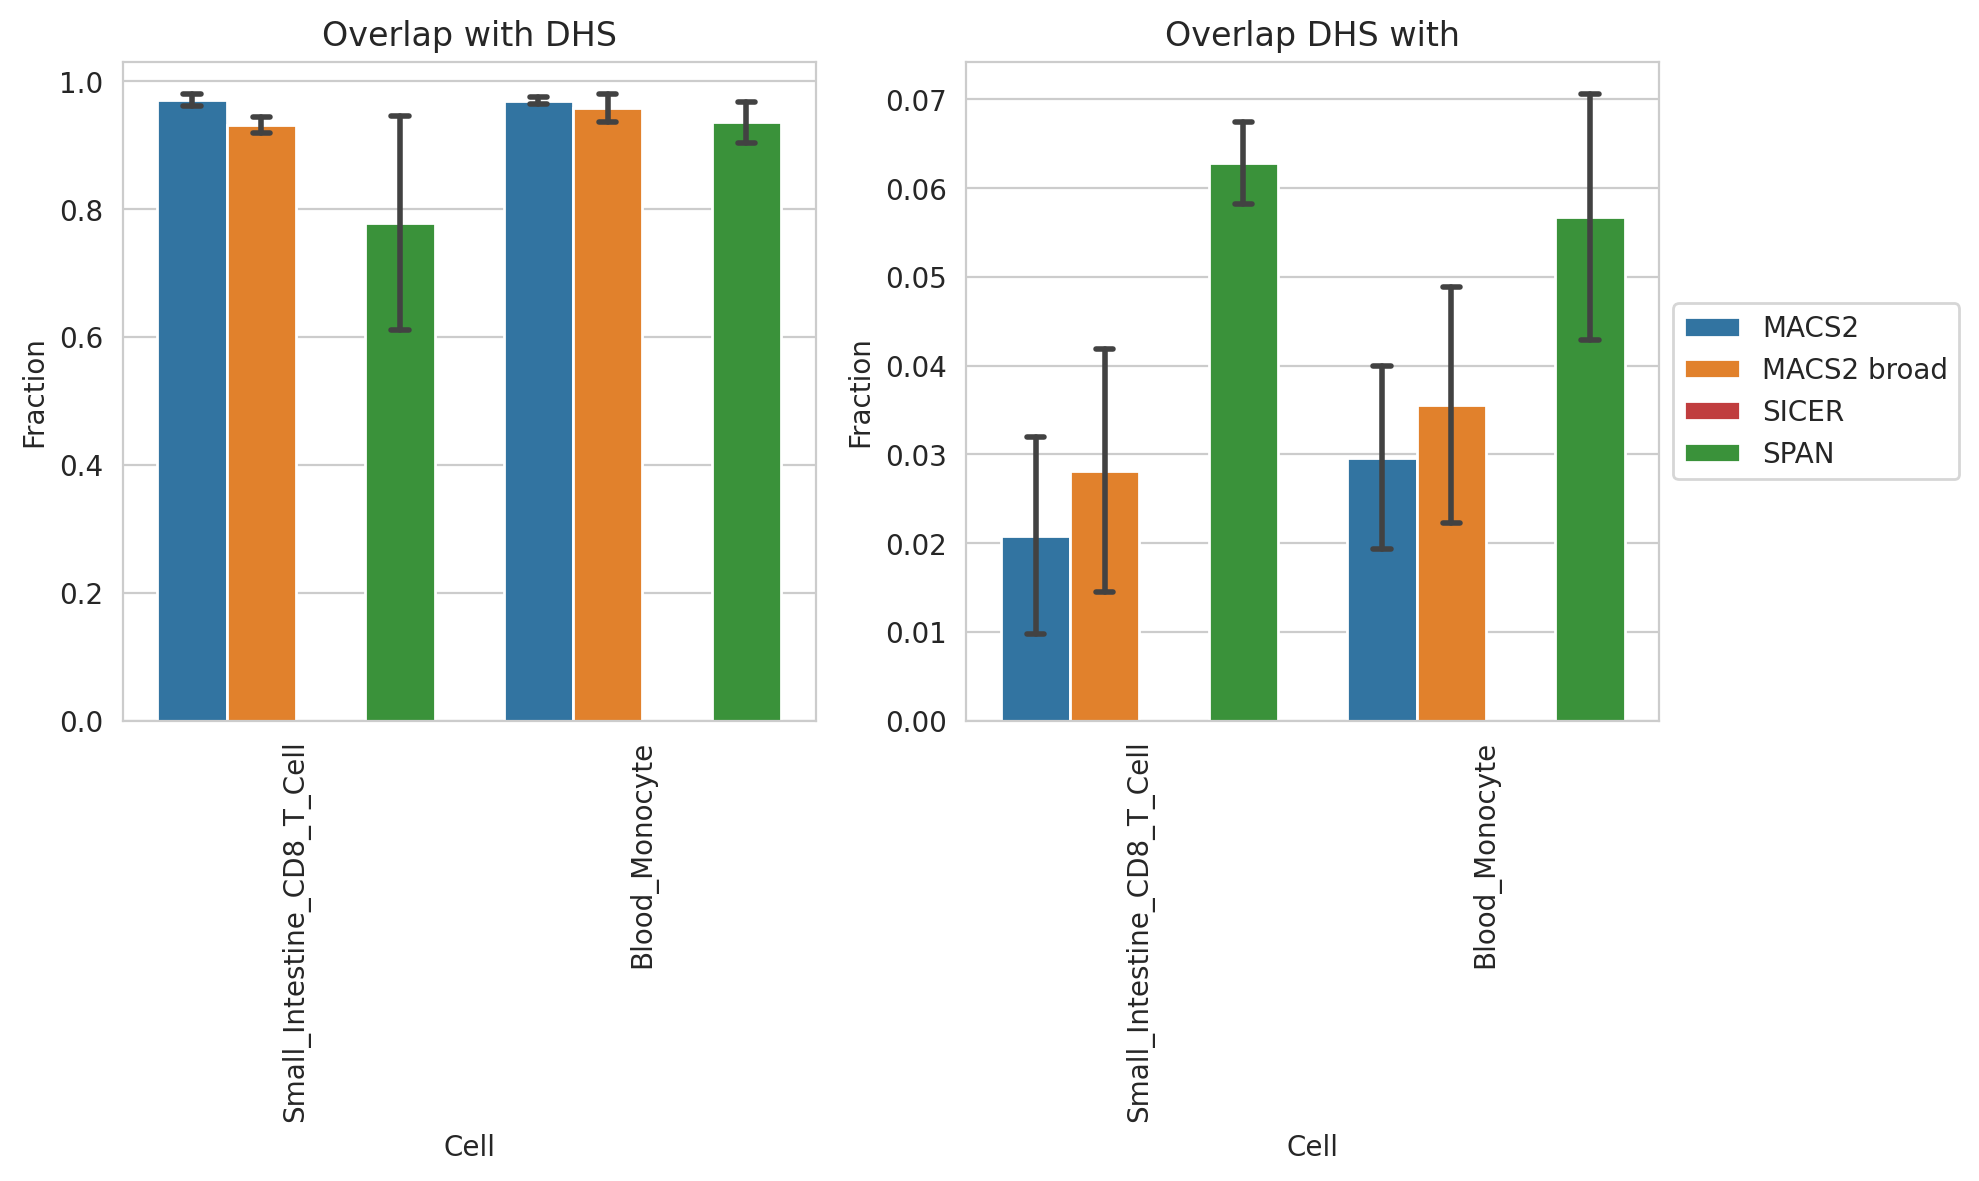

In [78]:
plt.figure(figsize=(10, 6))
# Plot 
ax = plt.subplot(1, 2, 1)
ax.title.set_text('Overlap with DHS')
sns.barplot(data=dhs_overlap[dhs_overlap['way']=='with_dhs'], x='name', y='overlap_share', hue='tool',
            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
            palette=TOOLS_PALETTE,
            errorbar='sd', capsize=.05, errwidth=2, ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('Cell')
ax.set_ylabel('Fraction')
ax.legend(loc='lower left', title='tool')
ax.legend().set_visible(False)

ax = plt.subplot(1, 2, 2)
ax.title.set_text('Overlap DHS with')
t = dhs_overlap[dhs_overlap['way']=='dhs_with'].copy()
t['overlap'].clip(upper=0.15, inplace=True)
sns.barplot(data=t, x='name', y='overlap_share', hue='tool',
            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
            palette=TOOLS_PALETTE,
            errorbar='sd', capsize=.05, errwidth=2, ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('Cell')
ax.set_ylabel('Fraction')
ax.legend(loc='lower left', title='tool')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f'{PATH}/pics/dhs.pdf', bbox_inches='tight', dpi=300)
plt.show()

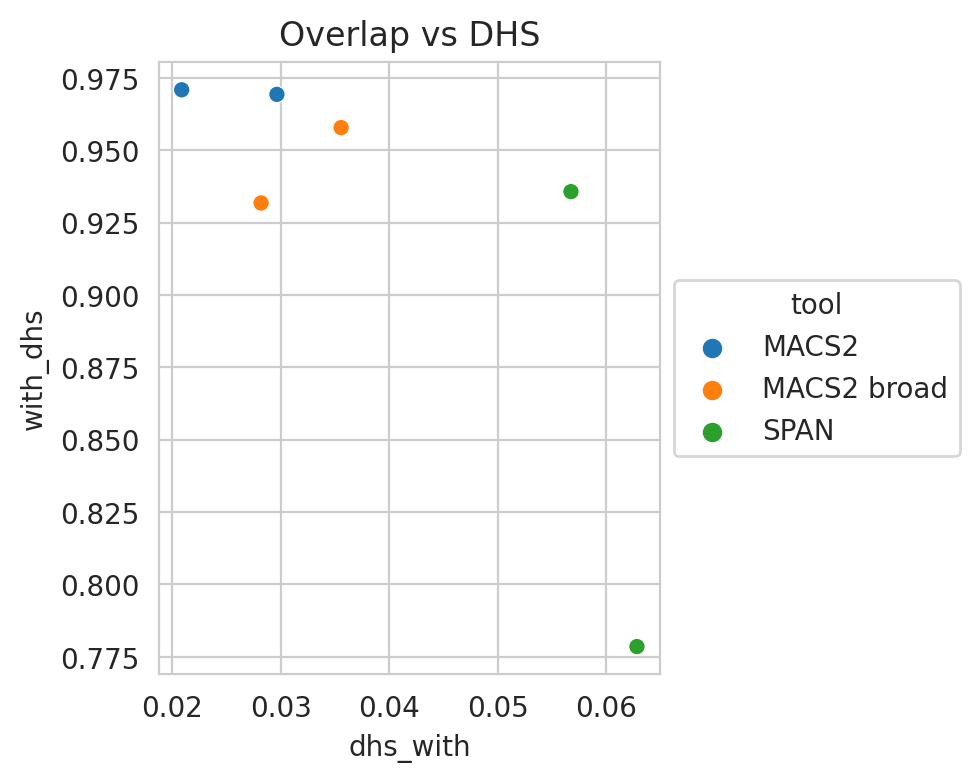

In [79]:
t = pd.pivot_table(dhs_overlap[['name', 'tool', 'way', 'overlap_share']], 
                   values='overlap_share', columns=['way'], index=['name', 'tool']).reset_index()


plt.figure(figsize=(5, 4))
ax = plt.axes()
sns.scatterplot(
    t[t['with_dhs'] > 0.6], x='dhs_with', y='with_dhs',
    hue='tool',
    hue_order=['MACS2', 'MACS2 broad', 'SPAN'],
    palette=TOOLS_PALETTE,
    ax = ax)
ax.title.set_text('Overlap vs DHS')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Top peaks vs DHS

In [80]:
import tempfile

def compute_dhs_overlaps_n(df):
    tf = tempfile.mktemp() 
    tf2 = tempfile.mktemp()
    rows = []
    for (srr, n, tool), dft in tqdm(list(df.groupby(['srr', 'name', 'tool']))):
        print('Processing', n, tool, len(dft))
        for _, row in dft.iterrows():
            peaks_file, peaks = sorted_file(row['file']), row['peaks']
            if peaks == 0:
                for top in np.linspace(1000, 30000, 5):
                    rows.append((srr, n, tool, top, DHS_PEAKS, peaks_file, 0, 0, 0))
                continue
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            # if len(t.columns) < 9:
            #     display(t.head())
            #     return 
            t.sort_values(by=[8] if len(t.columns) >= 9 else [3], ascending=False, inplace=True)
            for top in np.linspace(1000, 30000, 5):
                t.head(int(top)).sort_values(by=[0, 1]).to_csv(tf, sep='\t', index=False, header=None)
                tf = sorted_file(tf)
                peaks = lines(tf)
                ! bedtools intersect -a {tf} -b {dhs_path_sorted} -wa -u > {tf2}
                peaks_overlap = lines(tf2)
                ! bedtools intersect -b {tf} -a {dhs_path_sorted} -wa -u > {tf2}
                dhs_overlap = lines(tf2)
                rows.append((srr, n, tool, top, DHS_PEAKS, peaks_file, peaks, peaks_overlap, dhs_overlap))

    df = pd.DataFrame(
        rows,
        columns=['srr', 'name', 'tool', 'top', 'dhs_peaks', 'peaks_file', 'peaks', 'peaks_overlap', 'dhs_overlap'],
        dtype=object
    )
    return df

In [81]:
# dhs_ovlp_df = compute_dhs_overlaps_n(dfa[(dfa['tool'] != 'SICER') & (dfa['srr'] == 'SRR5799505')])  # Sample for testing
dhs_ovlp_df = compute_dhs_overlaps_n(dfa[(dfa['tool'] != 'SICER')])  # Sample for testing
dhs_ovlp_df.sample(3)

  0%|          | 0/24 [00:00<?, ?it/s]

Processing Small_Intestine_CD8_T_Cell MACS2 1
Processing Small_Intestine_CD8_T_Cell MACS2 broad 1
Processing Small_Intestine_CD8_T_Cell SPAN 1
Processing Small_Intestine_CD8_T_Cell MACS2 1
Processing Small_Intestine_CD8_T_Cell MACS2 broad 1
Processing Small_Intestine_CD8_T_Cell SPAN 1
Processing Blood_Monocyte MACS2 1
Processing Blood_Monocyte MACS2 broad 1
Processing Blood_Monocyte SPAN 1
Processing Blood_Monocyte MACS2 1
Processing Blood_Monocyte MACS2 broad 1
Processing Blood_Monocyte SPAN 1
Processing Blood_Monocyte MACS2 1
Processing Blood_Monocyte MACS2 broad 1
Processing Blood_Monocyte SPAN 1
Processing Blood_Monocyte MACS2 1
Processing Blood_Monocyte MACS2 broad 1
Processing Blood_Monocyte SPAN 1
Processing Blood_Monocyte MACS2 1
Processing Blood_Monocyte MACS2 broad 1
Processing Blood_Monocyte SPAN 1
Processing Blood_Monocyte MACS2 1
Processing Blood_Monocyte MACS2 broad 1
Processing Blood_Monocyte SPAN 1


,srr,name,tool,top,dhs_peaks,peaks_file,peaks,peaks_overlap,dhs_overlap
32,SRR5799491,Blood_Monocyte,MACS2,15500.0,1192301,/tmp/tmp3wf4g_3u,15500,15384,16973
115,SRR5799542,Blood_Monocyte,SPAN,1000.0,1192301,/tmp/tmpd8idvomp,1000,987,3118
62,SRR5799493,Blood_Monocyte,MACS2,15500.0,1192301,/tmp/tmpmmiklq97,15500,15394,17265


In [82]:
dhs_ovlp_df['p'] = (dhs_ovlp_df['peaks_overlap'] + dhs_ovlp_df['dhs_overlap']) / 2
dhs_ovlp_df['precision'] = [d(x, y) for x, y in zip(dhs_ovlp_df['peaks_overlap'], dhs_ovlp_df['peaks'])]
dhs_ovlp_df['sensitivity'] = [d(x, y) for x, y in zip(dhs_ovlp_df['dhs_overlap'], dhs_ovlp_df['dhs_peaks'])]
dhs_ovlp_df['f1'] = [
    2 / (d(1, s + 1e-10) + d(1, p + 1e-10))
    for s, p in zip(dhs_ovlp_df['sensitivity'], dhs_ovlp_df['precision'])]

In [83]:
dhs_ovlp_df.sample(3)

,srr,name,tool,top,dhs_peaks,peaks_file,peaks,peaks_overlap,dhs_overlap,p,precision,sensitivity,f1
91,SRR5799541,Blood_Monocyte,MACS2,8250.0,1192301,/tmp/tmpmqngtbvc,8250,8206,9056,8631.0,0.994667,0.007595,0.015076
22,SRR5799445,Small_Intestine_CD8_T_Cell,MACS2 broad,15500.0,1192301,/tmp/tmp8h4cw89e,15500,15051,19289,17170.0,0.971032,0.016178,0.031826
93,SRR5799541,Blood_Monocyte,MACS2,22750.0,1192301,/tmp/tmpmqngtbvc,22750,22442,23823,23132.5,0.986462,0.019981,0.039168


SRR5799444 Small_Intestine_CD8_T_Cell MACS2
SRR5799444 Small_Intestine_CD8_T_Cell MACS2 broad
SRR5799444 Small_Intestine_CD8_T_Cell SPAN
SRR5799445 Small_Intestine_CD8_T_Cell MACS2
SRR5799445 Small_Intestine_CD8_T_Cell MACS2 broad
SRR5799445 Small_Intestine_CD8_T_Cell SPAN
SRR5799491 Blood_Monocyte MACS2
SRR5799491 Blood_Monocyte MACS2 broad
SRR5799491 Blood_Monocyte SPAN
SRR5799492 Blood_Monocyte MACS2
SRR5799492 Blood_Monocyte MACS2 broad
SRR5799492 Blood_Monocyte SPAN
SRR5799493 Blood_Monocyte MACS2
SRR5799493 Blood_Monocyte MACS2 broad
SRR5799493 Blood_Monocyte SPAN
SRR5799494 Blood_Monocyte MACS2
SRR5799494 Blood_Monocyte MACS2 broad
SRR5799494 Blood_Monocyte SPAN
SRR5799541 Blood_Monocyte MACS2
SRR5799541 Blood_Monocyte MACS2 broad
SRR5799541 Blood_Monocyte SPAN
SRR5799542 Blood_Monocyte MACS2
SRR5799542 Blood_Monocyte MACS2 broad
SRR5799542 Blood_Monocyte SPAN


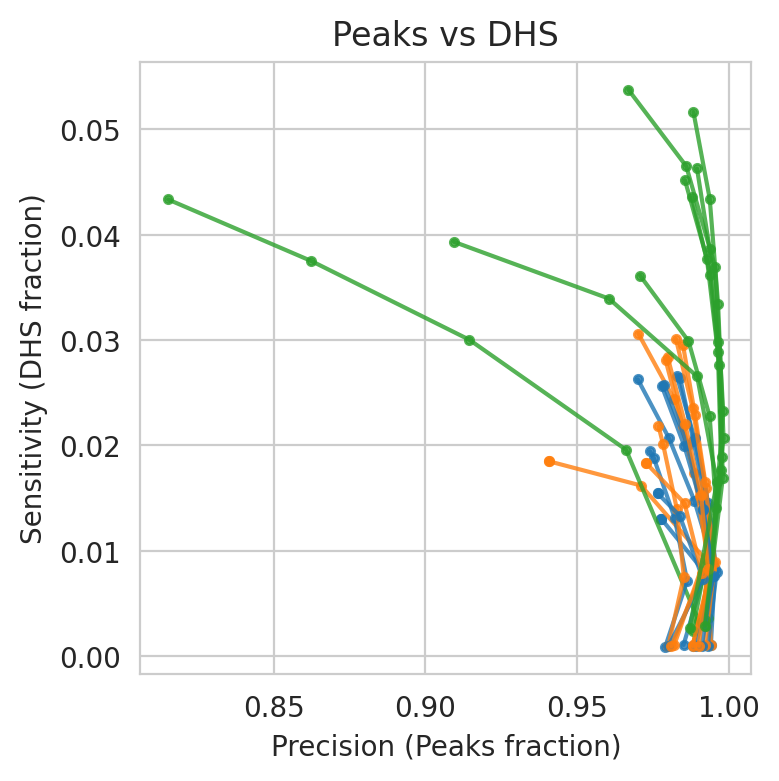

In [84]:
plt.figure(figsize=(4, 4))
for (srr, n, tool), dft in dhs_ovlp_df.groupby(['srr', 'name', 'tool']):
    print(srr, n, tool)
    plt.plot(dft['precision'], dft['sensitivity'], marker='.', 
             color=TOOLS_PALETTE[tool], alpha=0.8)
plt.title('Peaks vs DHS')
plt.xlabel('Precision (Peaks fraction)')
plt.ylabel('Sensitivity (DHS fraction)')
plt.tight_layout()
plt.show()

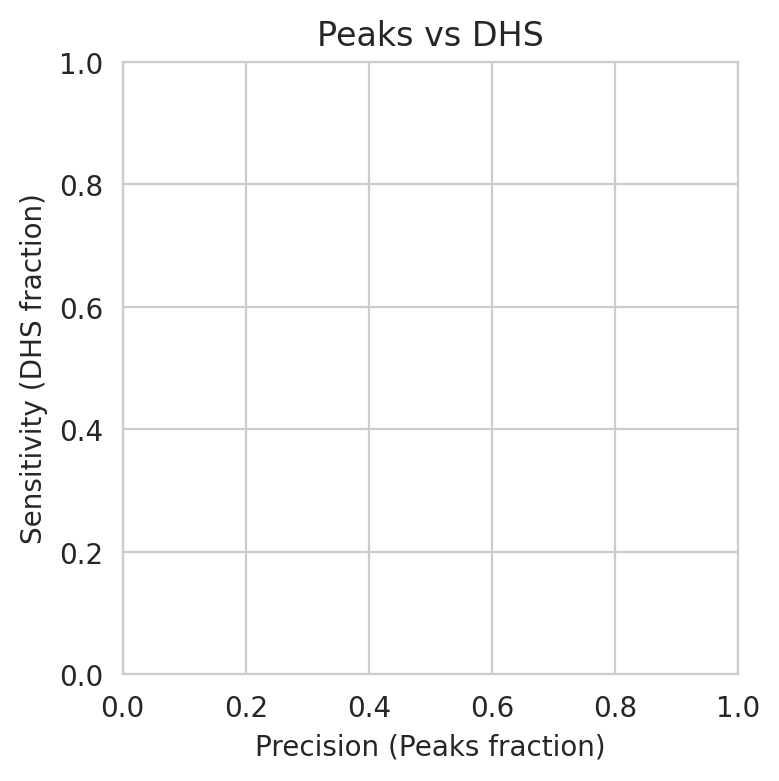

In [85]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
# Brain microglia
for (srr, n, tool), dft in dhs_ovlp_df[dhs_ovlp_df['srr'] == 'SRR5799505'].groupby(['srr', 'name', 'tool']):
    print(srr, n, tool)
    plt.plot(dft['precision'], dft['sensitivity'], marker='.', color=TOOLS_PALETTE[tool], alpha=0.8)
    for x, y, t in zip(dft['precision'], dft['sensitivity'], dft['top']):
        ax.text(x, y, str(int(t)), fontsize = 7)
plt.title('Peaks vs DHS')
plt.xlabel('Precision (Peaks fraction)')
plt.ylabel('Sensitivity (DHS fraction)')
plt.tight_layout()
plt.show()

/tmp/ipykernel_2545207/1002991112.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ENCODE + Roadmap


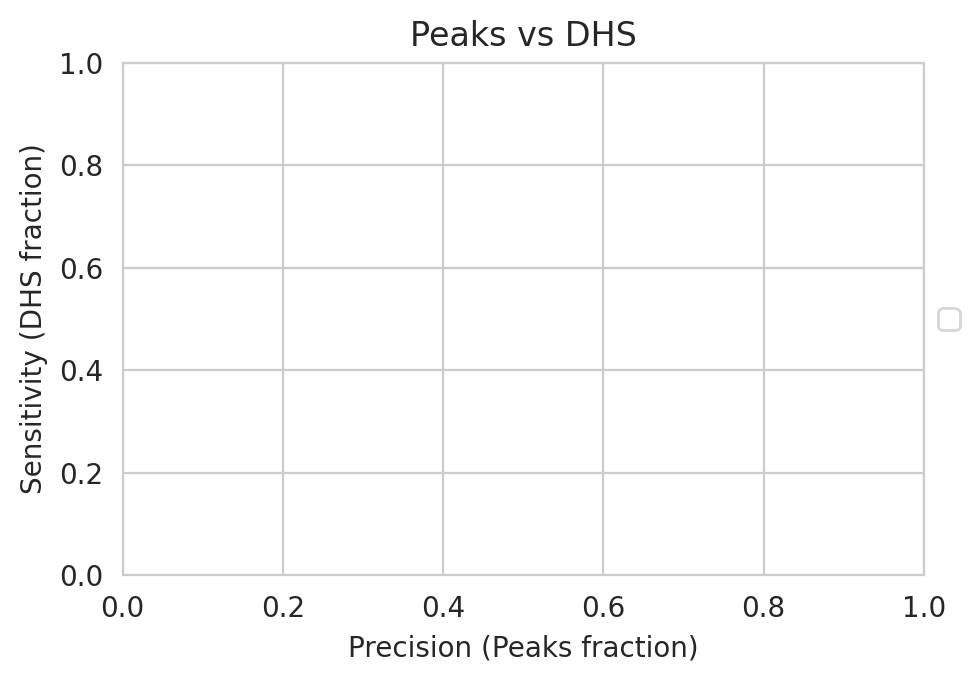

In [86]:
print('ENCODE + Roadmap')
plt.figure(figsize=(5, 3.5))
ax = plt.axes()
sns.lineplot(
    data=dhs_ovlp_df[(dhs_ovlp_df['srr'] == 'SRR5799505') & (dhs_ovlp_df['top'] >= 5000)],
    x='precision', y='sensitivity',
    hue='tool', marker='o',
    sort=False,
    palette=TOOLS_PALETTE,
    ax=ax
)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Peaks vs DHS')
plt.xlabel('Precision (Peaks fraction)')
plt.ylabel('Sensitivity (DHS fraction)')
plt.tight_layout()
plt.show()

In [87]:
rows = []
for (srr, n, tool), dft in dhs_ovlp_df.groupby(['srr', 'name', 'tool']):
    dft.sort_values(by=['top'], inplace=True)
    ap = 0
    sprev, pprev = 0, 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - sprev) * (row['precision'] + pprev) / 2
        sprev, pprev = row['sensitivity'], row['precision']
    rows.append((srr, n, tool, ap))
dhs_ovlp_df_df = pd.DataFrame(rows, columns=['srr', 'name', 'tool', 'auc'])
del rows
dhs_ovlp_df_df.sample(2)

,srr,name,tool,auc
15,SRR5799494,Blood_Monocyte,MACS2,0.024885
10,SRR5799492,Blood_Monocyte,MACS2 broad,0.020966


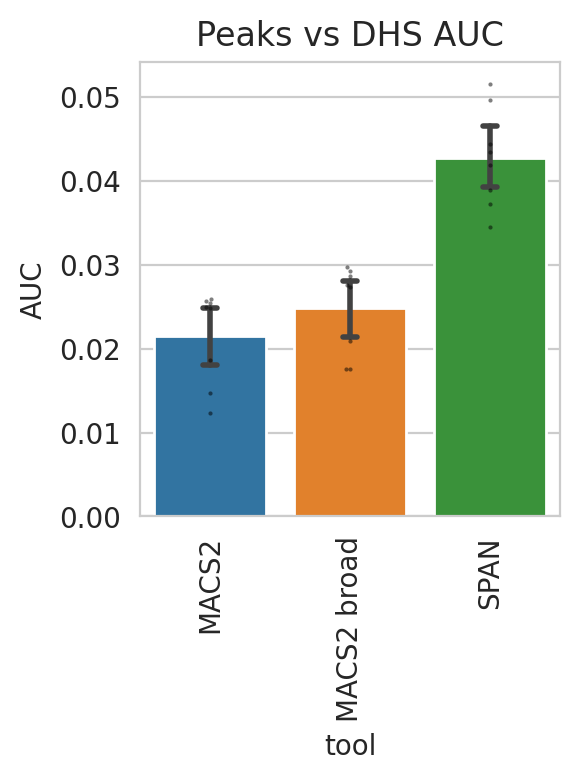

In [88]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs DHS AUC')
t = dhs_ovlp_df_df[dhs_ovlp_df_df['tool'] != 'SICER']
g_results = sns.barplot(data=t, x='tool', y='auc',
                        capsize=.1, errwidth=2,
                        ax=ax)
sns.swarmplot(data=t, x='tool', y='auc',
              dodge=True, size=1.5, color="black", alpha=0.5, 
              ax=ax)

ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.show()

In [89]:
STOP

NameError: name 'STOP' is not defined

# Automatic markup

See `2023_Immgen/create_markup.sh` and `2023_Immgen/span_tuned` for tuning SPAN.

# Bigwigs

In [45]:
def atac_load_bws(path):
    df = pd.DataFrame(columns=['file', 'srr', 'name'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bw'):
            continue
        file = os.path.join(path, f)
        df.loc[len(df)] = (file, file_to_srr(f), file_to_name(f))
    return df

df_bams = atac_load_bws(PATH + '/bw')
df_bams.sample(3)

  0%|          | 0/8 [00:00<?, ?it/s]

,file,srr,name
5,/home/jetbrains/data/2024_Immgen/bw/SRR5799445...,SRR5799445,Small_Intestine_CD8_T_Cell
6,/home/jetbrains/data/2024_Immgen/bw/SRR5799542...,SRR5799542,Blood_Monocyte
0,/home/jetbrains/data/2024_Immgen/bw/SRR5799541...,SRR5799541,Blood_Monocyte


In [46]:
import pyBigWig

CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(PATH, 'mm10.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}

total_coverages = {}
ts = []
for _, (file, srr, name) in tqdm(list(df_bams[['file', 'srr', 'name']].iterrows())):
    try:
        with pyBigWig.open(file) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr)
            print('Total coverage', total_coverage)
            # Multiplier to align BAM coverage with BigWig estimation
            total_coverage *= 1.1e-2
            total_coverages[(srr, name)] = total_coverage
    except Exception:
        pass

total_coverages

  0%|          | 0/8 [00:00<?, ?it/s]

Total coverage 63545909.384791374
Total coverage 69310119.13946962
Total coverage 67691134.44640613
Total coverage 76086385.54369259
Total coverage 73346286.79449415
Total coverage 66615684.58410931
Total coverage 72629991.32092237
Total coverage 74489124.97099876


{('SRR5799541', 'Blood_Monocyte'): 699005.003232705,
 ('SRR5799492', 'Blood_Monocyte'): 762411.3105341658,
 ('SRR5799494', 'Blood_Monocyte'): 744602.4789104674,
 ('SRR5799444', 'Small_Intestine_CD8_T_Cell'): 836950.2409806184,
 ('SRR5799491', 'Blood_Monocyte'): 806809.1547394356,
 ('SRR5799445', 'Small_Intestine_CD8_T_Cell'): 732772.5304252023,
 ('SRR5799542', 'Blood_Monocyte'): 798929.904530146,
 ('SRR5799493', 'Blood_Monocyte'): 819380.3746809864}

In [47]:
total_coverages_df = pd.DataFrame([(srr, name, reads) for (srr, name), reads in total_coverages.items()], columns=['srr', 'name', 'reads'])
total_coverages_df.sample(5)

,srr,name,reads
4,SRR5799491,Blood_Monocyte,806809.154739
1,SRR5799492,Blood_Monocyte,762411.310534
2,SRR5799494,Blood_Monocyte,744602.478910
7,SRR5799493,Blood_Monocyte,819380.374681
5,SRR5799445,Small_Intestine_CD8_T_Cell,732772.530425


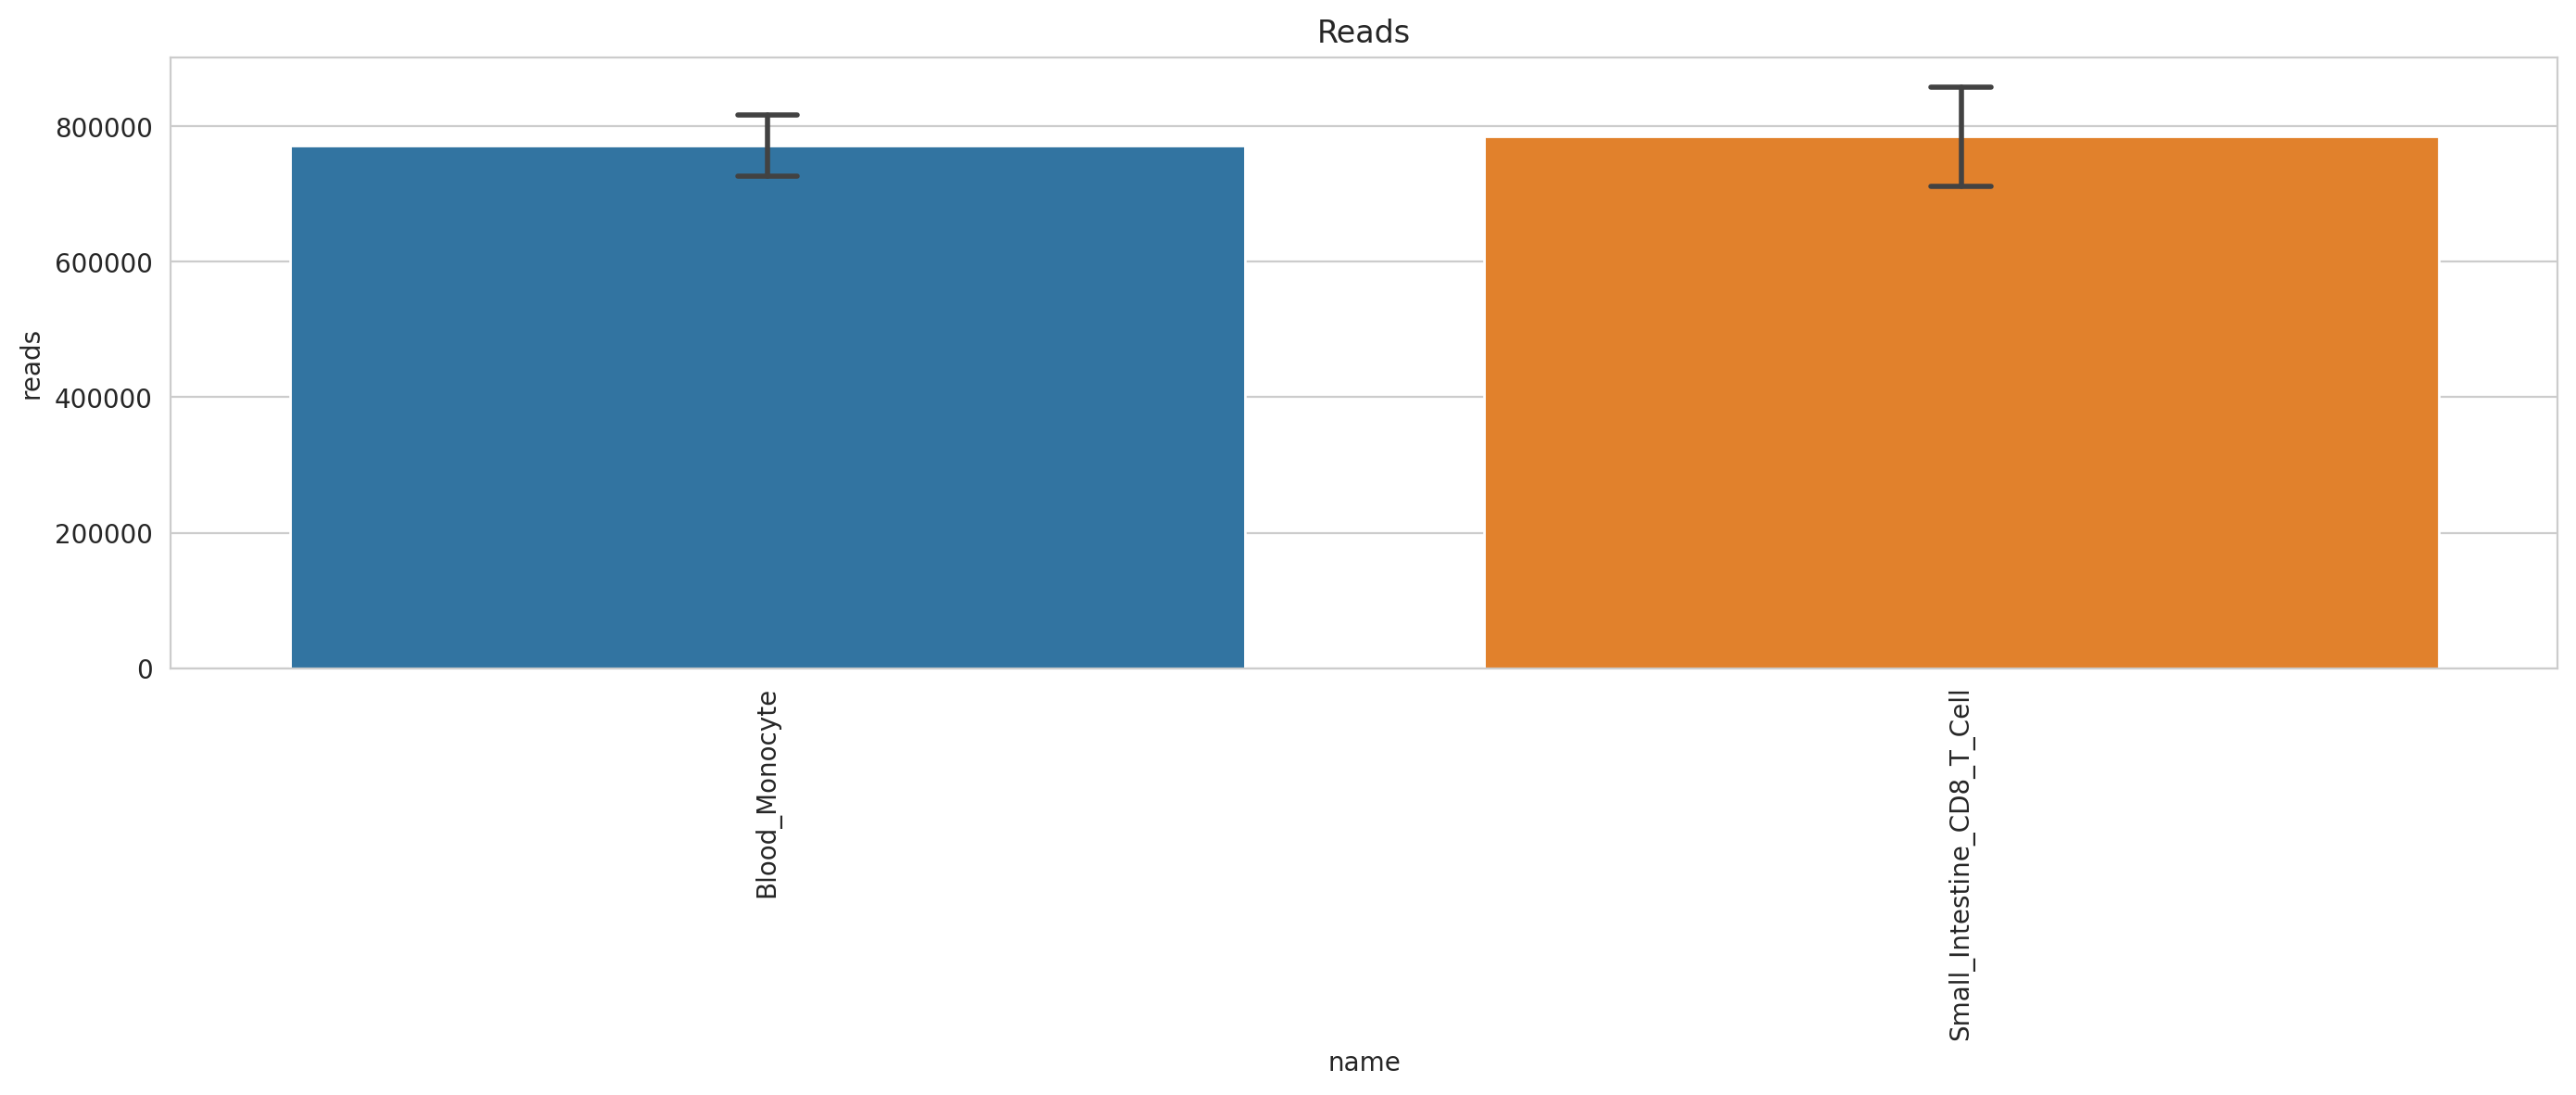

In [48]:
plt.figure(figsize=(14, 6))
g_result = sns.barplot(data=total_coverages_df, x='name', y='reads',
                       errorbar='sd', capsize=.05, errwidth=2)
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.title('Reads')
plt.tight_layout()
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference coverage

In [49]:
tf = tempfile.mktemp()

rows = []
for srr in tqdm(dfa['srr'].unique()):
    # if srr != 'SRR5799505':
    #     continue
    print(srr)
    t = dfa[(dfa['tool'] == 'SPAN') & (dfa['srr'] == srr)]
    if len(t) != 1:
        continue
    span_file = sorted_file(t['file'].values[0])
    cell_name = t['name'].values[0]
    totalm = total_coverages[(srr, cell_name)] * 1e-6
    # Processing single tools information
    bw_path = df_bams[(df_bams['srr'] == srr) & (df_bams['name'] == cell_name)]['file'].values[0]
    with pyBigWig.open(bw_path) as bw:
        for tool in dfa['tool'].unique():
            if tool == 'SPAN':
                continue
            t = dfa[(dfa['tool'] == tool) & (dfa['srr'] == srr)]
            if len(t) != 1:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
                !echo '' > {tf}
                !bedtools intersect {args} -wa -v > {tf}
                t2 = pd.read_csv(tf, sep='\t', header=None)
                # if len(t.columns) < 9:
                #     display(t.head())
                #     return 
                t2.sort_values(by=[8] if len(t2.columns) >= 9 else [3], ascending=False, inplace=True)
                t2 = t2[~t2[0].str.contains('M|_', regex=True)]
                for _, (chr, start, end) in t2.head(50)[[0, 1, 2]].iterrows():                
                    cov = bw.stats(chr, start, end, exact=True, type='sum')[0]
                    rpk = cov / (end - start) * 1e3
                    rpm = cov / totalm
                    rpkm = rpk / totalm
                    rows.append((srr, cell_name, name, len(t2), chr, start, end, end - start, rpk, rpm, rpkm))

diff_bench_coverage_df = pd.DataFrame(
    rows,
    columns=['srr', 'cell', 'name', 'peaks', 'chromosome', 'start', 'end', 'length', 'rpk', 'rpm', 'rpkm'],
    dtype=object
)
diff_bench_coverage_df.sample(3)

  0%|          | 0/8 [00:00<?, ?it/s]

SRR5799494
SRR5799491
SRR5799492
SRR5799493
SRR5799541
SRR5799542
SRR5799444
SRR5799445


,srr,cell,name,peaks,chromosome,start,end,length,rpk,rpm,rpkm
129,SRR5799494,Blood_Monocyte,SPAN - SICER,7464,chrX,20946070,20946280,210,355.755293,100.333552,477.778819
361,SRR5799491,Blood_Monocyte,MACS2 - SPAN,1417,chr14,122534058,122534546,488,3061.238461,1851.595709,3794.253502
735,SRR5799492,Blood_Monocyte,SPAN - SICER,9634,chr5,92348800,92349030,230,402.767961,121.504796,528.281723


Diff


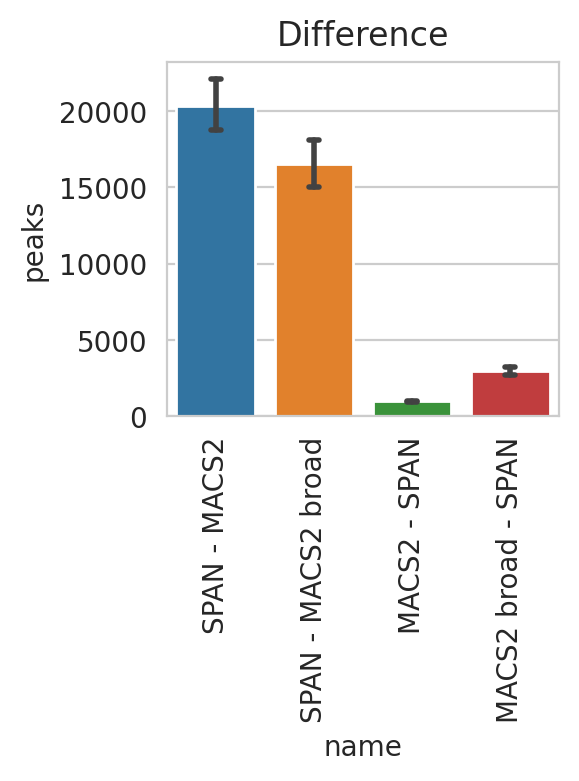

In [50]:
print('Diff')

plt.figure(figsize=(3, 4))
sns.barplot(data=diff_bench_coverage_df,
            x='name', y='peaks',
            order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'MACS2 - SPAN', 'MACS2 broad - SPAN'],
            capsize=.1, errwidth=2)
plt.xticks(rotation=90)
plt.title('Difference')
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/difference.pdf', bbox_inches='tight', dpi=300)
plt.show()

Diff


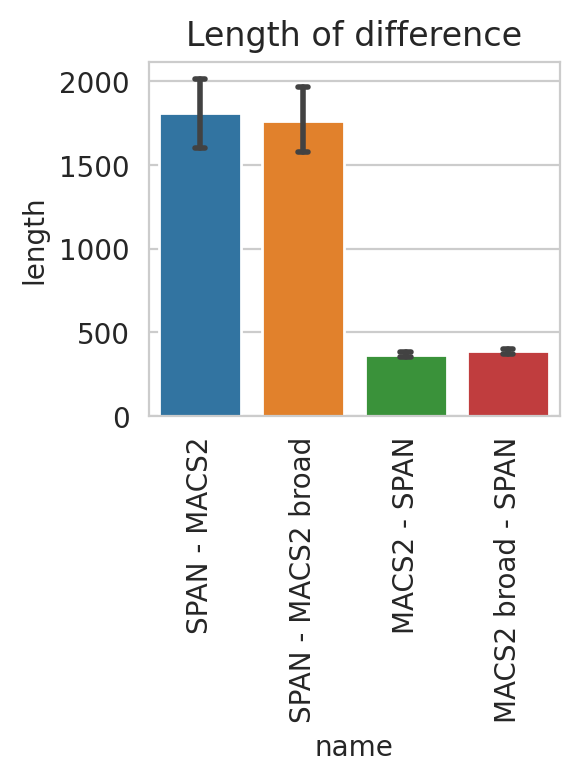

In [51]:
print('Diff')

plt.figure(figsize=(3, 4))
sns.barplot(data=diff_bench_coverage_df,
                       x='name', y='length',
                       order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'MACS2 - SPAN', 'MACS2 broad - SPAN'],
                       capsize=.1, errwidth=2,
                       )
plt.xticks(rotation=90)
plt.title('Length of difference')
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/difference.pdf', bbox_inches='tight', dpi=300)
plt.show()

Diff


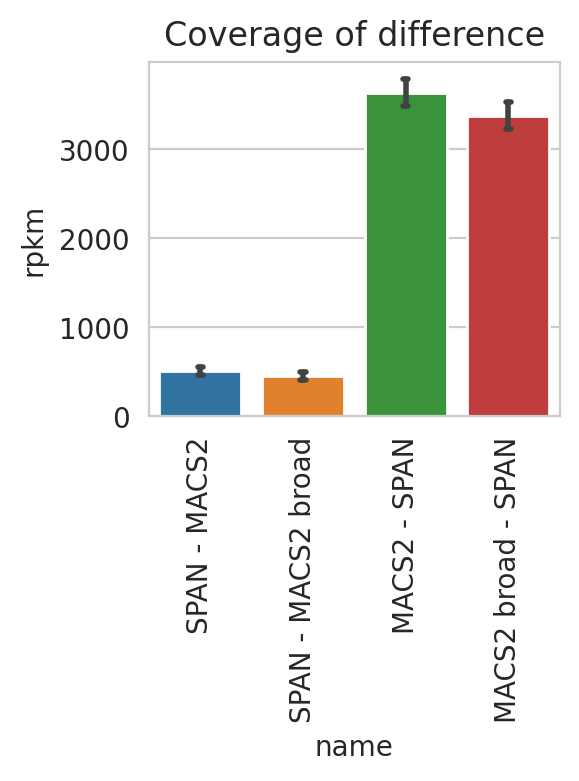

In [52]:
print('Diff')

plt.figure(figsize=(3, 4))
g_result = sns.barplot(data=diff_bench_coverage_df,
                       x='name', y='rpkm',
                       # order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER', 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN'],
                       order=['SPAN - MACS2', 'SPAN - MACS2 broad', 'MACS2 - SPAN', 'MACS2 broad - SPAN'],
                       capsize=.05, errwidth=2,
                       )
plt.xticks(rotation=90)
plt.title('Coverage of difference')
# g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{PATH}/pics/difference.pdf', bbox_inches='tight', dpi=300)
plt.show()